# Predicting the sale price of bulldozers using ML

## Problem definition:

predicting the sale price of bulldozers sold at auctions.

## Data

The data is downloaded from Kaggle. 
https://www.kaggle.com/c/bluebook-for-bulldozers/data

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this   set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with "machine configuration" in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.
The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).


## Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.





In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,precision_score,recall_score,f1_score,plot_roc_curve

In [20]:
# Importing training and validation sets
df = pd.read_csv("./bluebook-for-bulldozers/TrainAndValid/TrainAndValid.csv",low_memory=False)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

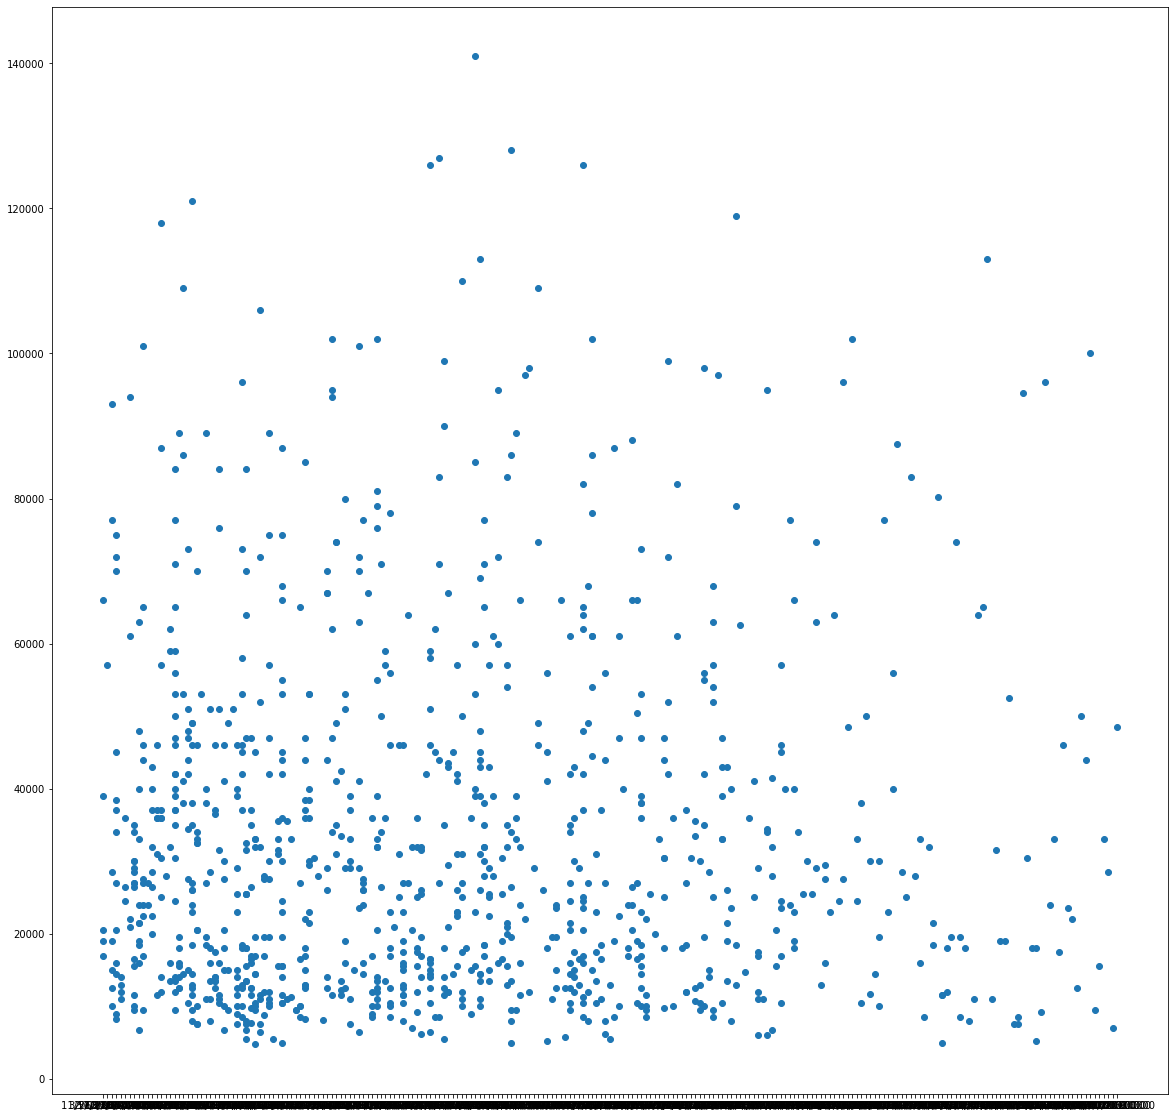

In [5]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

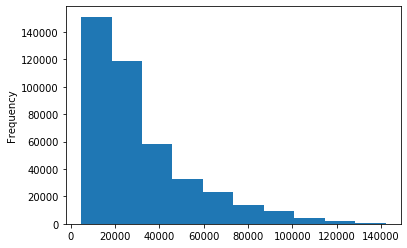

In [6]:
df.SalePrice.plot.hist()

## Parsing dates
Enriching the time and date


In [7]:
df = pd.read_csv("./bluebook-for-bulldozers/TrainAndValid/TrainAndValid.csv",low_memory=False, parse_dates=["saledate"])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate[:100]

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
        ...    
95   2005-12-15
96   2004-01-29
97   2008-09-18
98   2005-11-03
99   2006-06-01
Name: saledate, Length: 100, dtype: datetime64[ns]

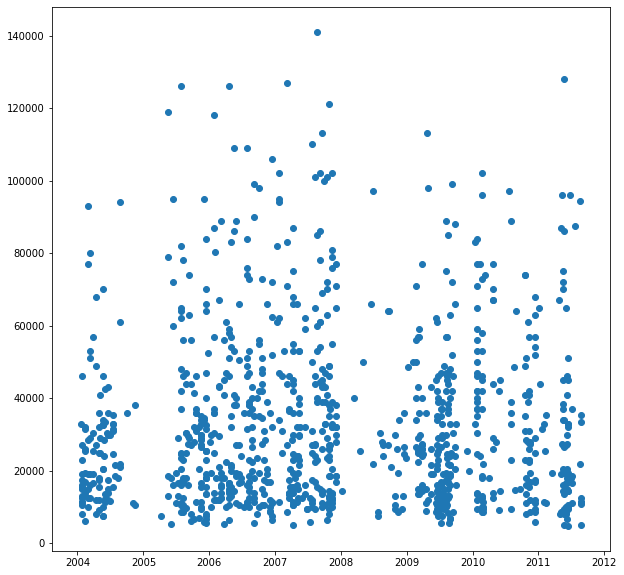

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

In [11]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [12]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

In [21]:
# sort dataframe by saledate
df.sort_values(by=["saledate"],inplace=True)
df.saledate.head(20)

405675     1/1/2012 0:00
268962    1/10/2003 0:00
221519    1/10/2003 0:00
283617    1/10/2003 0:00
122970    1/10/2003 0:00
121285    1/10/2003 0:00
237812    1/10/2003 0:00
10704     1/10/2005 0:00
51910     1/10/2008 0:00
11464     1/10/2008 0:00
11463     1/10/2008 0:00
5103      1/10/2008 0:00
175249    1/10/2008 0:00
9689      1/10/2008 0:00
536       1/10/2008 0:00
7279      1/10/2008 0:00
191798    1/10/2008 0:00
174911    1/10/2008 0:00
11428     1/10/2008 0:00
2117      1/10/2008 0:00
Name: saledate, dtype: object

# Make a copy of the original Dataframe

In [22]:
df_temp = df.copy()

##  Adding date time parameters for `saledate` column

In [17]:
df_temp["saleYear"]=df_temp.saledate.dt.year
df_temp["saleMonth"] = df_temp.saledate.dt.month
df_temp["saleDay"] = df_temp.saledate.dt.day
df_temp["saleDayofweek"] = df_temp.saledate.dt.dayofweek
df_temp["saleDayofyear"] = df_temp.saledate.dt.dayofyear


In [18]:
df_temp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


In [19]:
df_temp.drop("saledate",axis=1,inplace=True)

In [24]:
df_temp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## Modelling

In [23]:
# converting strings to categories

for  label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [24]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 405675 to 22602
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   saledate                  412698 non-null  category
 10  fiModelDesc               412698 non-null  category
 11  fiBaseModel               412698 non-null  category
 12  fiSecondaryDesc           271971 non-null  category
 13  fiModelSeries            

In [31]:
df_temp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [32]:
df_temp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [34]:
df_temp.isna().sum()/len(df_temp)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

# Save preprocessed data


In [35]:
df_temp.to_csv("./preprocessed_data.csv",index=False)

In [25]:
df_temp = pd.read_csv("preprocessed_data.csv",low_memory=False)

In [4]:
df_temp.isna().sum()/len(df_temp)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

In [5]:
# NUmerical missing values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear


In [6]:
#Checking if these columns have missing values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [26]:
#fill missing numeric rows with the median
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # add a binary column which tells us if the data was missing
            df_temp[label+"_is_missing"] = pd.isnull(content)
            # fill missing numeric values with median
            df_temp[label] = content.fillna(content.median()) #median is more robust than mean. Mean will become more sensistive to outliers.

In [8]:
df_temp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [27]:
# filling and turning categorical variables into numbers
for label,content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_temp[label+"_is_missing"] = pd.isnull(content)
        df_temp[label] = pd.Categorical(content).codes+1 #-1 are given for missing values. Hence we add +1.The missing values will become 0

In [10]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [11]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [12]:
df_temp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [28]:
%%time
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,random_state=42)

model.fit(df_temp.drop("SalePrice",axis=1),df_temp["SalePrice"])

Wall time: 4min 51s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [30]:
model.score(df_temp.drop("SalePrice",axis=1),df_temp["SalePrice"]) #This is not reliable

0.9875468079970563

In [31]:
# splitting the data into train and validation
df_val = df_temp[df_temp.saleYear==2012]
df_train = df_temp[df_temp.saleYear!=2012]
len(df_val),len(df_train)

(11573, 401125)

In [32]:
X_train,y_train = df_train.drop("SalePrice",axis=1),df_train.SalePrice
X_valid,y_valid = df_val.drop("SalePrice",axis=1),df_val.SalePrice
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

# Building an evaluation function (RMSLE)

In [5]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error,r2_score

def rmsle(y_test,y_preds):
    """
    Calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

#Create function to evaluate the model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MSE": mean_absolute_error(y_train,train_preds),
              "Valid MAE": mean_absolute_error(y_valid,val_preds),
            "Training RMSLE": rmsle(y_train,train_preds),
             "Valid RMSLE": rmsle(y_valid,val_preds),
            "Training R^2": r2_score(y_train,train_preds),
             "Valid R^2": r2_score(y_valid,val_preds)}
    return scores

# Tuning hyperparameters

In [19]:
# # This takes a long time
# %%time
# model = RandomForestRegressor(n_jobs=-1,random_state=42)

# model.fit(X_train,y_train)

In [17]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,random_state=42,max_samples=10000)

In [18]:
%%time
# cutting down on the max number of samples eah estimator can see improves training time
model.fit(X_train,y_train)

Wall time: 10.7 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [19]:
show_scores(model) #If valid MAE is higher than training MAE then the model is not over-fitting

{'Training MSE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

In [18]:
# hyperparameter tuning with randomisedsearchcv

rf_grid = {"n_estimators": np.arange(1,101,1),
        "max_depth": [None, 3,5,10],
        "min_samples_split": np.arange(2,20,2),
        "min_samples_leaf": np.arange(1,20,2),
        "max_features": [0.5,1,"sqrt","auto"]
        }

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42,max_samples=None),
                              param_distributions=rf_grid,
                              verbose=True,
                              n_iter=100,
                              cv=10)

rs_model.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 635.9min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                  

In [21]:
rs_model.best_params_

{'n_estimators': 62,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 0.5,
 'max_depth': None}

In [22]:
show_scores(rs_model)

{'Training MSE': 2862.03150663356,
 'Valid MAE': 5931.2315559026565,
 'Training RMSLE': 0.1430733232621176,
 'Valid RMSLE': 0.2434436072160405,
 'Training R^2': 0.9592517795003601,
 'Valid R^2': 0.8814452018488379}

In [2]:
from joblib import dump, load
dump(rs_model, 'Bulldozer final model.joblib') 

NameError: name 'rs_model' is not defined

In [3]:
rs_model = load('Bulldozer final model.joblib')

In [7]:
show_scores(rs_model)

NameError: name 'X_train' is not defined

In [8]:
df_test = pd.read_csv("./bluebook-for-bulldozers/Test.csv",low_memory=False,parse_dates=["saledate"])

In [9]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [10]:
test_preds = rs_model.predict(df_test)

ValueError: could not convert string to float: 'Low'

In [15]:
# preprocessing
def preprocess_data(df):
    df_test["saleYear"]=df_test.saledate.dt.year
    df_test["saleMonth"] = df_test.saledate.dt.month
    df_test["saleDay"] = df_test.saledate.dt.day
    df_test["saleDayofweek"] = df_test.saledate.dt.dayofweek
    df_test["saleDayofyear"] = df_test.saledate.dt.dayofyear

    df_test.drop("saledate",axis=1,inplace=True)
    #fill missing numeric rows with the median
    for label, content in df_test.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
            # add a binary column which tells us if the data was missing
                df_test[label+"_is_missing"] = pd.isnull(content)
            # fill missing numeric values with median
                df_test[label] = content.fillna(content.median()) #median is more robust than mean. Mean will become more sensistive to outliers.
    
    for label,content in df_test.items():
        if not pd.api.types.is_numeric_dtype(content):
            df_test[label+"_is_missing"] = pd.isnull(content)
            df_test[label] = pd.Categorical(content).codes+1 #-1 are given for missing values. Hence we add +1.The missing values will become 0
    
    return df

In [17]:
preprocess_data(df_test)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [18]:
test_preds = rs_model.predict(df_test)

ValueError: Number of features of the model must match the input. Model n_features is 102 and input n_features is 101 

In [33]:
set(X_train.columns)-set(df_test.columns)

{'auctioneerID_is_missing'}

In [34]:
df_test["auctioneerID_is_missing"] = False

In [35]:
test_preds = rs_model.predict(df_test)

In [36]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,22228.612596
1,1227844,20035.341616
2,1227847,52698.868135
3,1227848,61645.873675
4,1227863,42905.386324
...,...,...
12452,6643171,46522.231249
12453,6643173,13871.282737
12454,6643184,14560.303758
12455,6643186,19041.893208


In [37]:
df_preds.to_csv("./bluebook-for-bulldozers/test_predictions.csv",index=False)